In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce

In [2]:
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from keras_tqdm import TQDMNotebookCallback

In [100]:
def train(df1, df2):
    #Переводим timestamp в дату
    df1['date'] = pd.to_datetime(df1['timestamp'], unit='s')
    df1['day'] = df1['date'].dt.date
    
    #Отбираем 2 дня
    df1_2_days = df1[df1.groupby('user_id')['timestamp']\
                        .apply(lambda x: x <= (x.min()+ 2*24*60*60))]
    df2_2_days = df2[df2.groupby('user_id')['timestamp']\
                        .apply(lambda x: x <= (x.min()+ 2*24*60*60))]
    
    #Считаем количество действий для каждого пользователя
    users_score = df1_2_days.pivot_table(values = 'step_id',
                                         index='user_id',
                                         columns='action',
                                         aggfunc='count',
                                         fill_value=0).reset_index()
    #Считаем количество сабмитов для каждого пользователя
    submission_score = df2_2_days.pivot_table(values='step_id',
                                              index='user_id',
                                              columns='submission_status',
                                              aggfunc='count',
                                              fill_value=0).reset_index()
    #Считаем количество степов
    steps_tried = df2_2_days.groupby('user_id', as_index=False)\
                            .step_id.nunique()\
                            .rename(columns={'step_id':'steps_tried'})
    #Считаем количество уникальных дней активности пользователя
    nunique_day = df1_2_days.groupby('user_id', as_index=False).day.nunique()
    
    #Определяем, что пользователь закончит курс, если набрал больше 40 баллов
    submission_corrects = df2.query('submission_status=="correct"')\
                            .groupby('user_id', as_index=False)\
                            .agg({'step_id':'count'})\
                            .rename(columns={'step_id': 'corrects'})
    submission_corrects['is_gone'] = np.where(submission_corrects.corrects >= 40, 1, 0)
    submission_corrects = submission_corrects.drop('corrects',axis=1)
    
    #Объединяем датасеты
    data_frames = [users_score, submission_score,steps_tried, submission_corrects,nunique_day]
    users_score = reduce(lambda x, y: pd.merge(x, y, on='user_id', how='left'), data_frames).fillna(0)
    
    #Считаем соотношение правильных ответов ко всем
    users_score['correct_ratio'] = round((users_score.correct/(users_score.correct+users_score.wrong)), 2).fillna(0)
    
    return users_score

In [101]:
def test(df1, df2):
    #Переводим timestamp в дату
    df1['date'] = pd.to_datetime(df1['timestamp'], unit='s')
    df1['day'] = df1['date'].dt.date
    #Считаем количество действий для каждого пользователя
    users_score = df1.pivot_table(values = 'step_id',
                                  index='user_id',
                                  columns='action',
                                  aggfunc='count',
                                  fill_value=0).reset_index()
    #Считаем количество сабмитов для каждого пользователя
    submission_score = df2.pivot_table(values='step_id',
                                       index='user_id',
                                       columns='submission_status',
                                       aggfunc='count',
                                       fill_value=0).reset_index()
    #Считаем количество степов
    steps_tried = df2.groupby('user_id', as_index=False)\
                    .step_id.nunique()\
                    .rename(columns={'step_id':'steps_tried'})
    #Считаем количество уникальных дней активности пользователя
    nunique_day = df1.groupby('user_id', as_index=False).day.nunique()
    
    #Объединяем датасеты
    data_frames = [users_score, submission_score, steps_tried, nunique_day]
    users_score = reduce(lambda x, y: pd.merge(x, y, on='user_id', how='left'), data_frames).fillna(0)
    #Считаем соотношение правильных ответов ко всем
    users_score['correct_ratio'] = round((users_score.correct/(users_score.correct+users_score.wrong)), 2).fillna(0)

    return users_score

Считываем исходные данные

In [102]:
event_data=pd.read_csv('C:/Users/809688/event_data_train.csv')
event_data.head()

,step_id,timestamp,action,user_id
0,32815,1434340848,viewed,17632
1,32815,1434340848,passed,17632
2,32815,1434340848,discovered,17632
3,32811,1434340895,discovered,17632
4,32811,1434340895,viewed,17632


In [103]:
submissions_data = pd.read_csv("C:/Users/809688/submissions_data_train.csv")
submissions_data.head()

,step_id,timestamp,submission_status,user_id
0,31971,1434349275,correct,15853
1,31972,1434348300,correct,15853
2,31972,1478852149,wrong,15853
3,31972,1478852164,correct,15853
4,31976,1434348123,wrong,15853


Создаем обучающий датасет

In [104]:
train_df = train(event_data, submissions_data)

<AxesSubplot:>

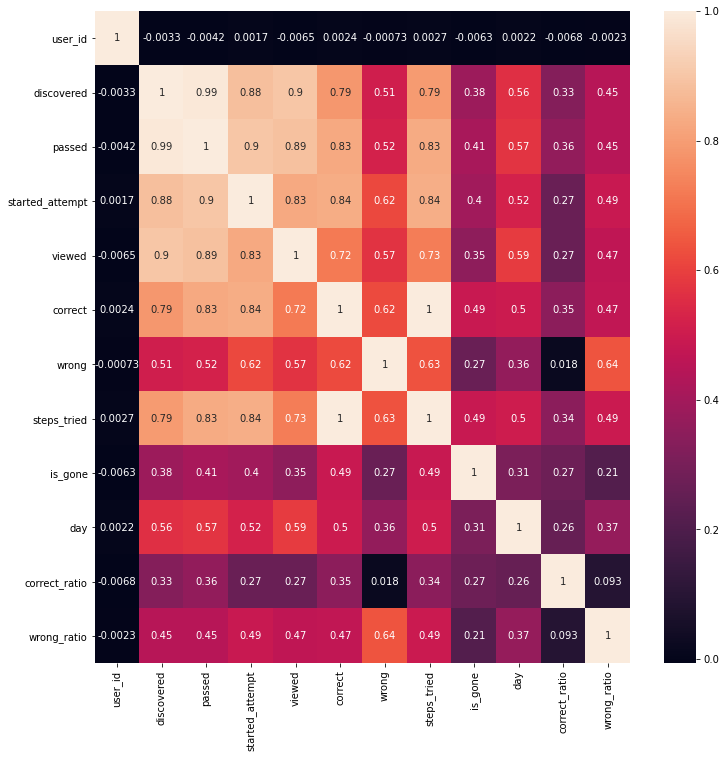

In [105]:
plt.figure(figsize=(12,12))
sns.heatmap(train_df.corr(),annot=True)

In [106]:
y = train_df.is_gone

Удаляем из обучающей выборки целевую переменную, а также user_id.

In [107]:
train_df = train_df.drop(['is_gone', 'user_id'], axis=1)

In [108]:
X_train, X_test, y_train, y_test = train_test_split(train_df,y, test_size=0.2, random_state=42)

Создаем классификатор

In [109]:
pipe = make_pipeline(RandomForestClassifier())

In [110]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('randomforestclassifier', RandomForestClassifier())])

In [111]:
parametrs={'randomforestclassifier__n_estimators': range(20, 40, 2), 
                  'randomforestclassifier__max_depth': range(3, 8)}

In [112]:
grid_search = GridSearchCV(pipe, parametrs, cv = 5)

In [113]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('randomforestclassifier',
                                        RandomForestClassifier())]),
             param_grid={'randomforestclassifier__max_depth': range(3, 8),
                         'randomforestclassifier__n_estimators': range(20, 40, 2)})

In [114]:
grid_search.best_estimator_

Pipeline(steps=[('randomforestclassifier',
                 RandomForestClassifier(max_depth=4, n_estimators=30))])

In [115]:
best_estimator = grid_search.best_estimator_

Проверяем точность классификатора на обучающей выборке

In [116]:
best_estimator.score(X_train, y_train)

0.9068694352375382

In [117]:
best_estimator.score(X_test, y_test)

0.9020015596568755

In [118]:
ypred_prob = best_estimator.predict_proba(X_test)

In [119]:
roc_auc_score(y_test, ypred_prob[:, 1])

0.8754697889563458

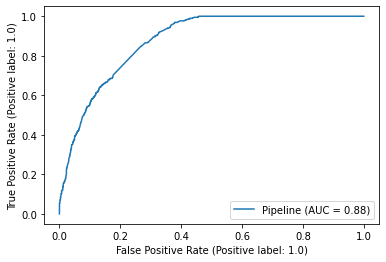

In [120]:
from sklearn import metrics

metrics.plot_roc_curve(best_estimator,X_test, y_test)

Подгружаем тестовые данные

In [121]:
events_data_test = pd.read_csv('C:/Users/809688/events_data_test.csv')

In [122]:
submission_data_test = pd.read_csv('C:/Users/809688/submission_data_test.csv')

Создаем тестовый датасет

In [123]:
test = test(events_data_test, submission_data_test)

In [124]:
X_test_f = test.drop(['user_id'], axis=1)

In [125]:
y_pred_f = best_estimator.predict_proba(X_test_f)

Загружаем полученные данные в файл

In [127]:
result = test['user_id'].to_frame()

In [128]:
result['is_gone'] = y_pred_f[:,1]

In [129]:
result[['user_id', 'is_gone']].to_csv('my_predict.csv', index=False)

Финальный результат на тестовой выборке 
Your ROC score is 0.8902669399801331